The next cell defines some helper functions that we can use to run the simulation and (if desired), 
print various quantities with nice formating.

## Liouville Equation Solver
Similar to `qutips` mesolve, I have implemented a method that solves the Liouville equation of motion for the density matrix using a 4th-order Runge-Kutta algorithm.  The Lioville equation gives how a given quantum state, represented by a density matrix, evoles with time:

$$ i \hbar \frac{\partial}{\partial t} D = [H, D] $$

where $H$ is a matrix representation of the Hamiltonian and $D$ is the density matrix defined as 

$$ D = |\Psi \rangle \langle \Psi | $$

In [1]:
# Function to compute the expectation value of the Hamiltonian for a given state
def compute_expectation_value(state, H):
    return np.vdot(state, H @ state)

def print_operator_action(op, ket, op_name="Operator", ket_name="Ket"):
    """ prints the action of an operator on a ket in a formatted way """
    result = op @ ket

    # Formatters
    fmt = {'all': lambda x: f"{x: 6.3f}"}

    print(f"\n=== {op_name} acting on {ket_name} ===\n")

    print(f"{op_name} matrix in tensor product space:")
    print(np.array2string(op, formatter=fmt))

    print(f"\n{ket_name} vector in tensor product space:")
    print(np.array2string(ket.reshape(-1, 1), formatter=fmt))

    print(f"\nResulting vector in tensor product space ({op_name} ⋅ {ket_name}):")
    print(np.array2string(result.reshape(-1, 1), formatter=fmt))

def represent_basis_in_eigen(basis_names, eigvecs, energies=None, tol=1e-6):
    """
    For each original basis state |b_j>, prints its expansion
      |b_j> = sum_i c_{j,i} |ψ_i>
    where c_{j,i} = <ψ_i|b_j> = conj(eigvecs[j, i]) for a unitary eigvecs.
    
    Parameters
    ----------
    basis_names : list of str
        Names of the basis kets in the same order as the rows of eigvecs.
    eigvecs : np.ndarray, shape (N, N)
        Columns are the eigenvectors |ψ_i> expressed in the original basis.
    energies : array-like, optional
        If provided, labels the eigenstates by energy order.
    tol : float
        Threshold below which coefficients are treated as zero.
    """
    N = eigvecs.shape[0]
    assert eigvecs.shape == (N, N)
    assert len(basis_names) == N

    # If energies given, label states by E; otherwise by index
    labels = []
    if energies is not None:
        for i, E in enumerate(energies, 1):
            labels.append(f"ψ_{i} (E={E:.4f})")
    else:
        labels = [f"ψ_{i}" for i in range(1, N+1)]

    for j, name in enumerate(basis_names):
        # coefficients c_{j,i} = <ψ_i|b_j> = conj(eigvecs[j,i])
        coefs = np.conj(eigvecs[j, :])
        terms = []
        for i, c in enumerate(coefs):
            if abs(c) < tol:
                continue
            # format complex; drop imaginary part if ~0
            if abs(c.imag) < tol:
                terms.append(f"{c.real:+.4f}·|{labels[i]}>")
            else:
                terms.append(f"({c.real:+.4f}{c.imag:+.4f}j)·|{labels[i]}>")
        combo = "  +  ".join(terms) if terms else "0"
        print(f"|{name}> = {combo}\n")

# simple function for printing real part of complex matrix
def complex_formatter(x):
    return f"{x.real: .2f}" #{x.imag:+.2f}j"

def commutator(A, B):
    """Compute the commutator [A, B] = AB - BA"""
    return A @ B - B @ A

def liouville_rhs(H, rho, hbar=1.0):
    """Compute the right-hand side of the Liouville-von Neumann equation: -i/hbar * [H, rho]"""
    return -1j / hbar * commutator(H, rho)

def rk4_step(rho, H, dt, hbar=1.0):
    """
    Apply a single RK4 step to evolve the density matrix rho using a time-independent Hamiltonian H.

    Parameters:
    - rho: numpy.ndarray, the current density matrix
    - H: numpy.ndarray, the time-independent Hamiltonian
    - dt: float, time step
    - hbar: float, Planck's reduced constant (default = 1.0)

    Returns:
    - rho_next: numpy.ndarray, the updated density matrix after one time step
    """
    k1 = liouville_rhs(H, rho, hbar)
    k2 = liouville_rhs(H, rho + 0.5 * dt * k1, hbar)
    k3 = liouville_rhs(H, rho + 0.5 * dt * k2, hbar)
    k4 = liouville_rhs(H, rho + dt * k3, hbar)

    rho_next = rho + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return rho_next



# 🧩 Step 1: Defining the Hamiltonian

## 🎯 Learning Outcomes
By the end of this step, you should be able to:
- Explain the terms in the Hamiltonian for two qubits (two independent two-level systems) coupled to a cavity (Tavis–Cummings model).  
- Explain how cavity-mediated coupling enables excitation transfer between two qubits 
- Represent the Hamiltonian in a tensor product basis between uncoupled qubit and cavity states 
- Understand how coupling two qubits to a cavity can facilitate the generation of entangled states known as Bell states

---


## 🧮 Representing the states of our system
We will represent the states of our system in a basis of uncoupled qubit and photon occupation states.

The basis states for the qubit are as follows:

$$
|g\rangle = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
$$
$$
|e\rangle =
\begin{bmatrix}
0 \\
1
\end{bmatrix},
$$
and similarly for the cavity,
$$
|0\rangle = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
$$
$$
|1\rangle = 
\begin{bmatrix}
0 \\
1
\end{bmatrix},
$$
where we truncate caity states at $|1\rangle$. 
The **uncoupled basis** for the cavity and two qubits can be represented as:

\begin{align}
|0\rangle \otimes |g\rangle \otimes |g\rangle, \\
|0\rangle \otimes |g\rangle \otimes |e\rangle, \\
|0\rangle \otimes |e\rangle \otimes |g\rangle, \\
|0\rangle \otimes |e\rangle \otimes |e\rangle, \\
|1\rangle \otimes |g\rangle \otimes |g\rangle, \\
|1\rangle \otimes |g\rangle \otimes |e\rangle, \\
|1\rangle \otimes |e\rangle \otimes |g\rangle, \\
|1\rangle \otimes |e\rangle \otimes |e\rangle.
\end{align}

---

Next we will introduce the Tavis-Cummings model that includes an interaction between each qubit and the cavity.

## 🔬 The Tavis–Cummings Hamiltonian
For two-level systems  coupled to an $N$-level cavity:  

$$
H = \sum_i -\frac{\hbar \omega_i}{2} \sigma_{z,i} + \hbar \omega a^\dagger a 
   + \sum_i \hbar g_i ( a \sigma_{+,i} + a^\dagger \sigma_{-,i} )
$$

---

### ⚡ Term 1: Bare qubit Hamiltonian

Each two-level system (qubit) has an energy splitting described by:

$$
H_{\text{qubit},i} = -\frac{\hbar \omega_i}{2} \, \sigma_{z,i}
$$

with Pauli matrix:

$$
\sigma_z =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

So for one qubit:

$$
H_{\text{qubit}} =
\begin{bmatrix}
-\frac{\hbar}{\omega} & 0 \\
0 & \frac{\hbar}{\omega}
\end{bmatrix}
$$

---

### 📡 Term 2: Bare cavity Hamiltonian

The free Hamiltonian of the cavity mode is:

$$
H_{\text{cavity}} = \hbar \omega \, a^\dagger a
$$

If we truncate the Fock space to $|0\rangle, |1\rangle$:

$$
a^\dagger a =
\begin{bmatrix}
0 & 0 \\
0 & 1
\end{bmatrix}
$$

So:

$$
H_{\text{cavity}} =
\begin{bmatrix}
0 & 0 \\
0 & \hbar \omega
\end{bmatrix}
$$

---

### 🔄 Term 3: Interaction Hamiltonian

The interaction term couples the cavity photons to the qubits through the exchange of an excitation.  

$$
H_{\text{int}} = \hbar g \, \left( a \, \sigma_{+} + a^\dagger \, \sigma_{-} \right)
$$

where we can interpret the operator $\sigma_{+}$ as an operator that takes the qubit from the ground to excited state, $\sigma_{-}$ takes the qubit from the excited to ground state, $a^\dagger$ takes excites the cavity by one, and $a$ de-excites the cavity by one.  The matrix form of these operators follows:

$$
\sigma_- =
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}, \qquad
\sigma_+ =
\begin{bmatrix}
0 & 0 \\
1 & 0
\end{bmatrix}
$$

and the cavity ladder operators truncated to $ |0\rangle, |1\rangle $:

$$
a =
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}, \qquad
a^\dagger =
\begin{bmatrix}
0 & 0 \\
1 & 0
\end{bmatrix}
$$

So the coupling block looks like:

$$
\hbar g (a \sigma_+ + a^\dagger \sigma_-) \quad \longrightarrow \quad
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & \hbar g & 0 \\
0 & \hbar g & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

(in the truncated $|0\rangle \otimes |g\rangle, |0\rangle \otimes |e\rangle, |1\rangle \otimes g\rangle, |1\rangle \otimes e\rangle$ basis).
Physically, you can think of this interaction as moving excitations between the qubit and the cavity!

---

✨ Putting all terms together gives the Tavis–Cummings Hamiltonian in block-matrix form, built from:
- **Qubit terms**: diagonal blocks ($-\hbar \omega/2 \, \sigma_z$)  
- **Cavity term**: photon number operator ($\hbar \omega a^\dagger a$)  
- **Interaction**: off-diagonal couplings that exchange excitations between the cavity and qubit(s).  

---

## ⚡ Physical Picture: Generating Bell states via cavity coupling
We model the following process to evolve an initial factorizable state to a non-factorizable (entangled) Bell state

1. **Initial excitation**: At $t=0$, molecule 1 is excited and coupled to the cavity,
   
   $$|\Psi(t=0)\rangle = |0\rangle \otimes |e\rangle \otimes |g\rangle$$
   
2. **Excitation transfer**: Over time $T_1$, molecule 1 exchanges energy with the cavity,
 
 $$|\Psi(t=T_1)\rangle = \left( c_{0e} |0\rangle \otimes |e\rangle + c_{1g} |1\rangle \otimes |g\rangle \right) \otimes |g\rangle $$

3. **Switch coupling**: At $T_1$, molecule 1 decouples and molecule 2 couples.  
4. **Final exchange**: By $T_2$, molecule 2 has exchanged energy with the cavity.  

 $$|\Psi(t=T_2)\rangle = |0\rangle \otimes \left( c_{eg} |e\rangle \otimes |g\rangle + c_{ge} |g\rangle \otimes |e\rangle \right)$$

If $T_1$ and $T_2$ are designed properly, the qubits end in a **Bell state**:

$$
|\Psi(t_f)\rangle = \sqrt{\tfrac{1}{2}} \left( |g\rangle \otimes |e\rangle \;-\; |e\rangle \otimes |g\rangle \right)
$$

---

💡 **Note:**  
We can gain intuition from **polaritonic structure calculations** (e.g., QED-CI).  
It’s natural to represent molecule–cavity systems in the **polariton basis**, then add vibronic coupling on top.  

In this notebook, we’ll:  
- Attempt an iSWAP implementation *without vibronic states*.  
- Perform the simulation in both the **polariton basis** and the **uncoupled basis**.  
- Show that they can yield the same results.  
- Use only `numpy` (but you should compare to a `qutip` implementation).  

---

### ❓ Checkpoint Question
What does truncating the cavity photon states at \(|1\rangle\) mean physically?  
- Why is this a reasonable approximation for an iSWAP implementation?  

⬜ *Your answer:*  
…

<details>
<summary><strong>Hint</strong> (click to expand)</summary>
Think about energy conservation: in this model, you only ever need at most **one excitation** in the combined molecule–cavity system.
</details>



## 🧮 Step 2: Building the Basis States

Now we’ll explicitly construct the **uncoupled basis states** by taking tensor products of the cavity states \(|0\rangle, |1\rangle\) and the molecular states \(|g\rangle, |e\rangle\).

🎯 Learning outcomes:
- Represent cavity and molecular states as column vectors.  
- Use tensor products (`np.kron`) to build composite states.  
- Confirm the basis matches the order written in the previous section.  


In [2]:
import numpy as np
import scipy.linalg as la

# --- Basis vectors for individual subsystems ---
z_ket = np.array([[1], [0]])  # |0> cavity state
o_ket = np.array([[0], [1]])  # |1> cavity state

g_ket = np.array([[1], [0]])  # |g> ground state of a molecule
e_ket = np.array([[0], [1]])  # |e> excited state of a molecule

# --- Tensor products to build composite states ---
zgg_ket = np.kron(z_ket, np.kron(g_ket, g_ket))  # |0> ⊗ |g> ⊗ |g>
zge_ket = np.kron(z_ket, np.kron(g_ket, e_ket))  # |0> ⊗ |g> ⊗ |e>
zeg_ket = np.kron(z_ket, np.kron(e_ket, g_ket))  # |0> ⊗ |e> ⊗ |g>
zee_ket = np.kron(z_ket, np.kron(e_ket, e_ket))  # |0> ⊗ |e> ⊗ |e>

ogg_ket = np.kron(o_ket, np.kron(g_ket, g_ket))  # |1> ⊗ |g> ⊗ |g>
oge_ket = np.kron(o_ket, np.kron(g_ket, e_ket))  # |1> ⊗ |g> ⊗ |e>
oeg_ket = np.kron(o_ket, np.kron(e_ket, g_ket))  # |1> ⊗ |e> ⊗ |g>
oee_ket = np.kron(o_ket, np.kron(e_ket, e_ket))  # |1> ⊗ |e> ⊗ |e>


## Step 2: Constructing the Hamiltonian

We'll now set up the Hamiltonian matrix in Python for the 2-level atom and 2-level cavity.

In [3]:
# Define the Hamiltonian parameters
omega_0 = 1.0  # Atomic frequency (in arbitrary units)
omega = 1.0    # Cavity frequency (in arbitrary units)
g = 0.1        # Coupling strength (in arbitrary units)
hbar = 1.0     # Reduced Planck's constant (set to 1 for simplicity)

# Gate times
T1_time = np.pi / (4 * g)
T2_time = 2 * np.pi / (4 * g)


# Define the Pauli matrices for the atom Hilbert space (N = 2)
sigma_z = np.array([[1, 0], [0, -1]])
sigma_minus = np.array([[0, 1], [0, 0]])  # this is defined such that sigma_minus |e> = |g>
sigma_plus = np.array([[0, 0], [1, 0]])   # this is defined such that sigma_plus |g> = |e>

# Define the creation and annihilation operators for the cavity Hilber space (N=2)
a = np.array([[0, 1], [0, 0]])                # annihilation operator, defined such that a |1> = |0>
a_dagger = np.array([[0, 0], [1, 0]])         # creation operator, defined such that a_dagger |0> = |1>

# create identities for each Hilbert space
Icav = np.eye(2)
Iq   = np.eye(2)

# create operators in tripartitie space
sz1 = np.kron( Icav, np.kron(sigma_z, Iq))
sp1 = np.kron( Icav, np.kron(sigma_plus, Iq))
sm1 = np.kron( Icav, np.kron(sigma_minus, Iq))

sz2 = np.kron( Icav, np.kron(Iq, sigma_z))
sp2 = np.kron( Icav, np.kron(Iq, sigma_plus))
sm2 = np.kron( Icav, np.kron(Iq, sigma_minus))

am = np.kron( a, np.kron(Iq, Iq))
ap = np.kron( a_dagger, np.kron(Iq, Iq))

# build Hamiltonian for coupling molecule 1 to the cavity in the composite space
H1 =  -hbar * omega_0 / 2 * sz1 
H1 -=  hbar * omega_0 / 2 * sz2
H1 +=  hbar * omega * ap @ am
H1 +=  hbar * g * am @ sp1
H1 +=  hbar * g * ap @ sm1

# build the Hamiltonian for coupling molecule 2 to the cavity in the composite space
H2 = np.copy(H1)
H =  np.copy(H1)
H2 +=  hbar * g * am @ sp2
H2 +=  hbar * g * ap @ sm2
H2 -=  hbar * g * am @ sp1
H2 -=  hbar * g * ap @ sm1

# This hamiltonian captures coupling of molecule 1 and molecule 2 to the cavity; not currently used
# but maybe it will come in handy later
H +=  hbar * g * am @ sp2
H +=  hbar * g * ap @ sm2




In [4]:
np.kron(sigma_plus, a)
np.kron(sigma_minus, a_dagger)

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [5]:
# Compute eigenvalues and eigenvectors of the Hamiltonian
eigenvalues_1, polariton_1 = np.linalg.eigh(H1)
eigenvalues_2, polariton_2 = np.linalg.eigh(H2)



# Express H1 and H2 in the basis that diagonalizes H1
H_pol1 = polariton_1.T @ H1 @ polariton_1
H_pol2 = polariton_1.T @ H2 @ polariton_1 # This is not a typoe, I want to do everything in the basis that diagonalizes H1


In [6]:
# You can run this to see what the eigenstates of H1 look like in terms of basis states!
basis_names = ['zgg', 'zge', 'zeg', 'zee', 'ogg', 'oge', 'oeg', 'oee']

for i, (E, vec) in enumerate(zip(eigenvalues_1, polariton_1.T), 1):
    if i < 5:
        print(f"Eigenstate #{i}:  E = {E:.6f}")
        for name, amp in zip(basis_names, vec):
            print(f"   ⟨{name}|ψ_{i}⟩ = {amp:+.4f}")
        print()



Eigenstate #1:  E = -1.000000
   ⟨zgg|ψ_1⟩ = +1.0000
   ⟨zge|ψ_1⟩ = +0.0000
   ⟨zeg|ψ_1⟩ = +0.0000
   ⟨zee|ψ_1⟩ = +0.0000
   ⟨ogg|ψ_1⟩ = +0.0000
   ⟨oge|ψ_1⟩ = +0.0000
   ⟨oeg|ψ_1⟩ = +0.0000
   ⟨oee|ψ_1⟩ = +0.0000

Eigenstate #2:  E = -0.100000
   ⟨zgg|ψ_2⟩ = -0.0000
   ⟨zge|ψ_2⟩ = -0.0000
   ⟨zeg|ψ_2⟩ = -0.7071
   ⟨zee|ψ_2⟩ = +0.0000
   ⟨ogg|ψ_2⟩ = +0.7071
   ⟨oge|ψ_2⟩ = -0.0000
   ⟨oeg|ψ_2⟩ = -0.0000
   ⟨oee|ψ_2⟩ = -0.0000

Eigenstate #3:  E = 0.000000
   ⟨zgg|ψ_3⟩ = +0.0000
   ⟨zge|ψ_3⟩ = +1.0000
   ⟨zeg|ψ_3⟩ = +0.0000
   ⟨zee|ψ_3⟩ = +0.0000
   ⟨ogg|ψ_3⟩ = +0.0000
   ⟨oge|ψ_3⟩ = +0.0000
   ⟨oeg|ψ_3⟩ = +0.0000
   ⟨oee|ψ_3⟩ = +0.0000

Eigenstate #4:  E = 0.100000
   ⟨zgg|ψ_4⟩ = +0.0000
   ⟨zge|ψ_4⟩ = +0.0000
   ⟨zeg|ψ_4⟩ = -0.7071
   ⟨zee|ψ_4⟩ = +0.0000
   ⟨ogg|ψ_4⟩ = -0.7071
   ⟨oge|ψ_4⟩ = +0.0000
   ⟨oeg|ψ_4⟩ = +0.0000
   ⟨oee|ψ_4⟩ = +0.0000



In [7]:
# you can run this to show how the uncoupled basis states are expressed in terms of polariton1 basis states
basis_names = ['zgg', 'zge', 'zeg', 'zee', 'ogg', 'oge', 'oeg', 'oee']

# Print each original basis state in the eigenbasis:
represent_basis_in_eigen(basis_names, polariton_1, energies=eigenvalues_1)




|zgg> = +1.0000·|ψ_1 (E=-1.0000)>

|zge> = +1.0000·|ψ_3 (E=0.0000)>

|zeg> = -0.7071·|ψ_2 (E=-0.1000)>  +  -0.7071·|ψ_4 (E=0.1000)>

|zee> = +0.7071·|ψ_5 (E=0.9000)>  +  +0.7071·|ψ_7 (E=1.1000)>

|ogg> = +0.7071·|ψ_2 (E=-0.1000)>  +  -0.7071·|ψ_4 (E=0.1000)>

|oge> = -0.7071·|ψ_5 (E=0.9000)>  +  +0.7071·|ψ_7 (E=1.1000)>

|oeg> = +1.0000·|ψ_6 (E=1.0000)>

|oee> = +1.0000·|ψ_8 (E=2.0000)>



This cell creates the initial state $|0\rangle \otimes |e\rangle \otimes |g\rangle $ in the uncoupled
basis and in terms of the polariton states.

In the uncoupled basis, the initial density matrix can be computed as 

$$ |0\rangle \otimes |e\rangle \otimes |g\rangle  \langle g | \otimes \langle e | \otimes \langle 0 | $$

In [8]:

# get the density matrix representation of this state
rho_zeg = np.outer(zeg_ket, zeg_ket.T)




The following block will do the following in the uncoupled basis:
1. Solve the Liouville equation using $H_1$ until time $T_1$
2. Solve the Liouville equation using $H_2$ until time $T_2$
3. At each time step, we will get the diagonals of the density matrix which represent the population in a
given basis state at each point in time.

**Question** Explain in a few sentences what physical situation this is simulating.

In [9]:
# number of time steps
n_time = 400

# make copies of initial density matrices
### in uncoupled basis
rho_init = np.copy(rho_zeg)


# define timestep
dt = 0.1

n_time_1 = T1_time / dt  # number of time steps for the first gate
n_time_2 = T2_time / dt  # number of time steps for the second gate


t = []

# array to store the populations at each time-step
pops_uncoupled = np.zeros((n_time,rho_init.shape[0]))


for i in range(n_time):
    if i<n_time_1:
        # evolve in uncoupled basis by H1
        rho_new = rk4_step(rho_init, H1, dt, hbar=1.0)

    elif i < (n_time_1 + n_time_2):
        # evolve in uncoupled basis by H2
        rho_new = rk4_step(rho_init, H2, dt, hbar=1)


    t.append(i * dt)
    for k in range(rho_init.shape[0]):
        # store all populations
        pops_uncoupled[i,k] = np.real(rho_new[k,k])


    # copy updated rhos in each basis to the rho_init and rho_pol_init for next step
    rho_init = np.copy(rho_new)


    
        

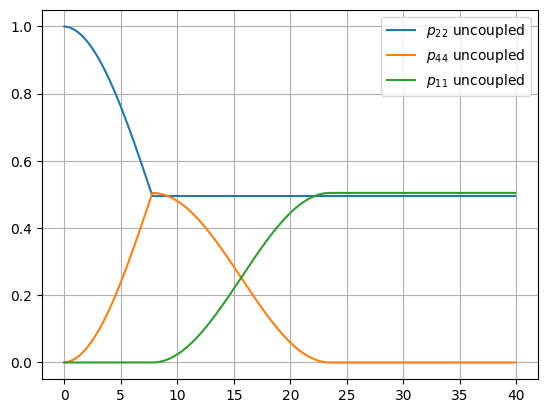

In [10]:
from matplotlib import pyplot as plt
plt.plot(t, pops_uncoupled[:,2], label="$p_{22}$ uncoupled")
plt.plot(t, pops_uncoupled[:,4], label="$p_{44}$ uncoupled")
plt.plot(t, pops_uncoupled[:,1], label="$p_{11}$ uncoupled")
plt.grid()
#plt.xlim(10,20)
plt.legend()
plt.show()

In [11]:
print(np.array2string(rho_new, formatter={'all': complex_formatter}))

[[ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.50 -0.50  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -0.50  0.50  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]]


Let's see how this compares to the target Bell state 

$$ |\Psi\rangle = \sqrt{\frac{1}{2}} \left(|g\rangle \otimes |e\rangle - |e\rangle \otimes |g \rangle  \right) $$

if we assume that the cavity is in the ground state for each term, i.e.

$$ |\Psi\rangle = \sqrt{\frac{1}{2}} \left(  |0\rangle \otimes |g\rangle \otimes |e\rangle  - |0\rangle \otimes |e\rangle \otimes |g \rangle  \right) $$

In [12]:
target_ket = np.sqrt(1/2) * (zge_ket - zeg_ket)
target_rho = np.outer(target_ket, target_ket.T)
print("\nTarget density matrix:")
print(np.array2string(target_rho, formatter={'all': complex_formatter}))

fidelity = np.real(np.trace(la.sqrtm(la.sqrtm(target_rho) @ rho_new @ la.sqrtm(target_rho))))**2
print(f"\nFidelity with target Bell state: {fidelity:.6f}")


Target density matrix:
[[ 0.00  0.00 -0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.50 -0.50  0.00  0.00  0.00  0.00  0.00]
 [-0.00 -0.50  0.50 -0.00 -0.00 -0.00 -0.00 -0.00]
 [ 0.00  0.00 -0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00 -0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00 -0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00 -0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00 -0.00  0.00  0.00  0.00  0.00  0.00]]

Fidelity with target Bell state: 0.999979
